In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = pd.read_excel('data1.xlsx', usecols=[10,2,3,5])
data.head()

温度   乙醇转化率(%)  C4烯烃选择性(%)  ID
0  250   2.067169       34.05  A1
1  275   5.851721       37.43  A1
2  300  14.968891       46.94  A1
3  325  19.681359       49.70  A1
4  350  36.801017       47.21  A1

可以大致观察到乙醇转化率和C4烯烃选择性同温度的正相关性都比较大

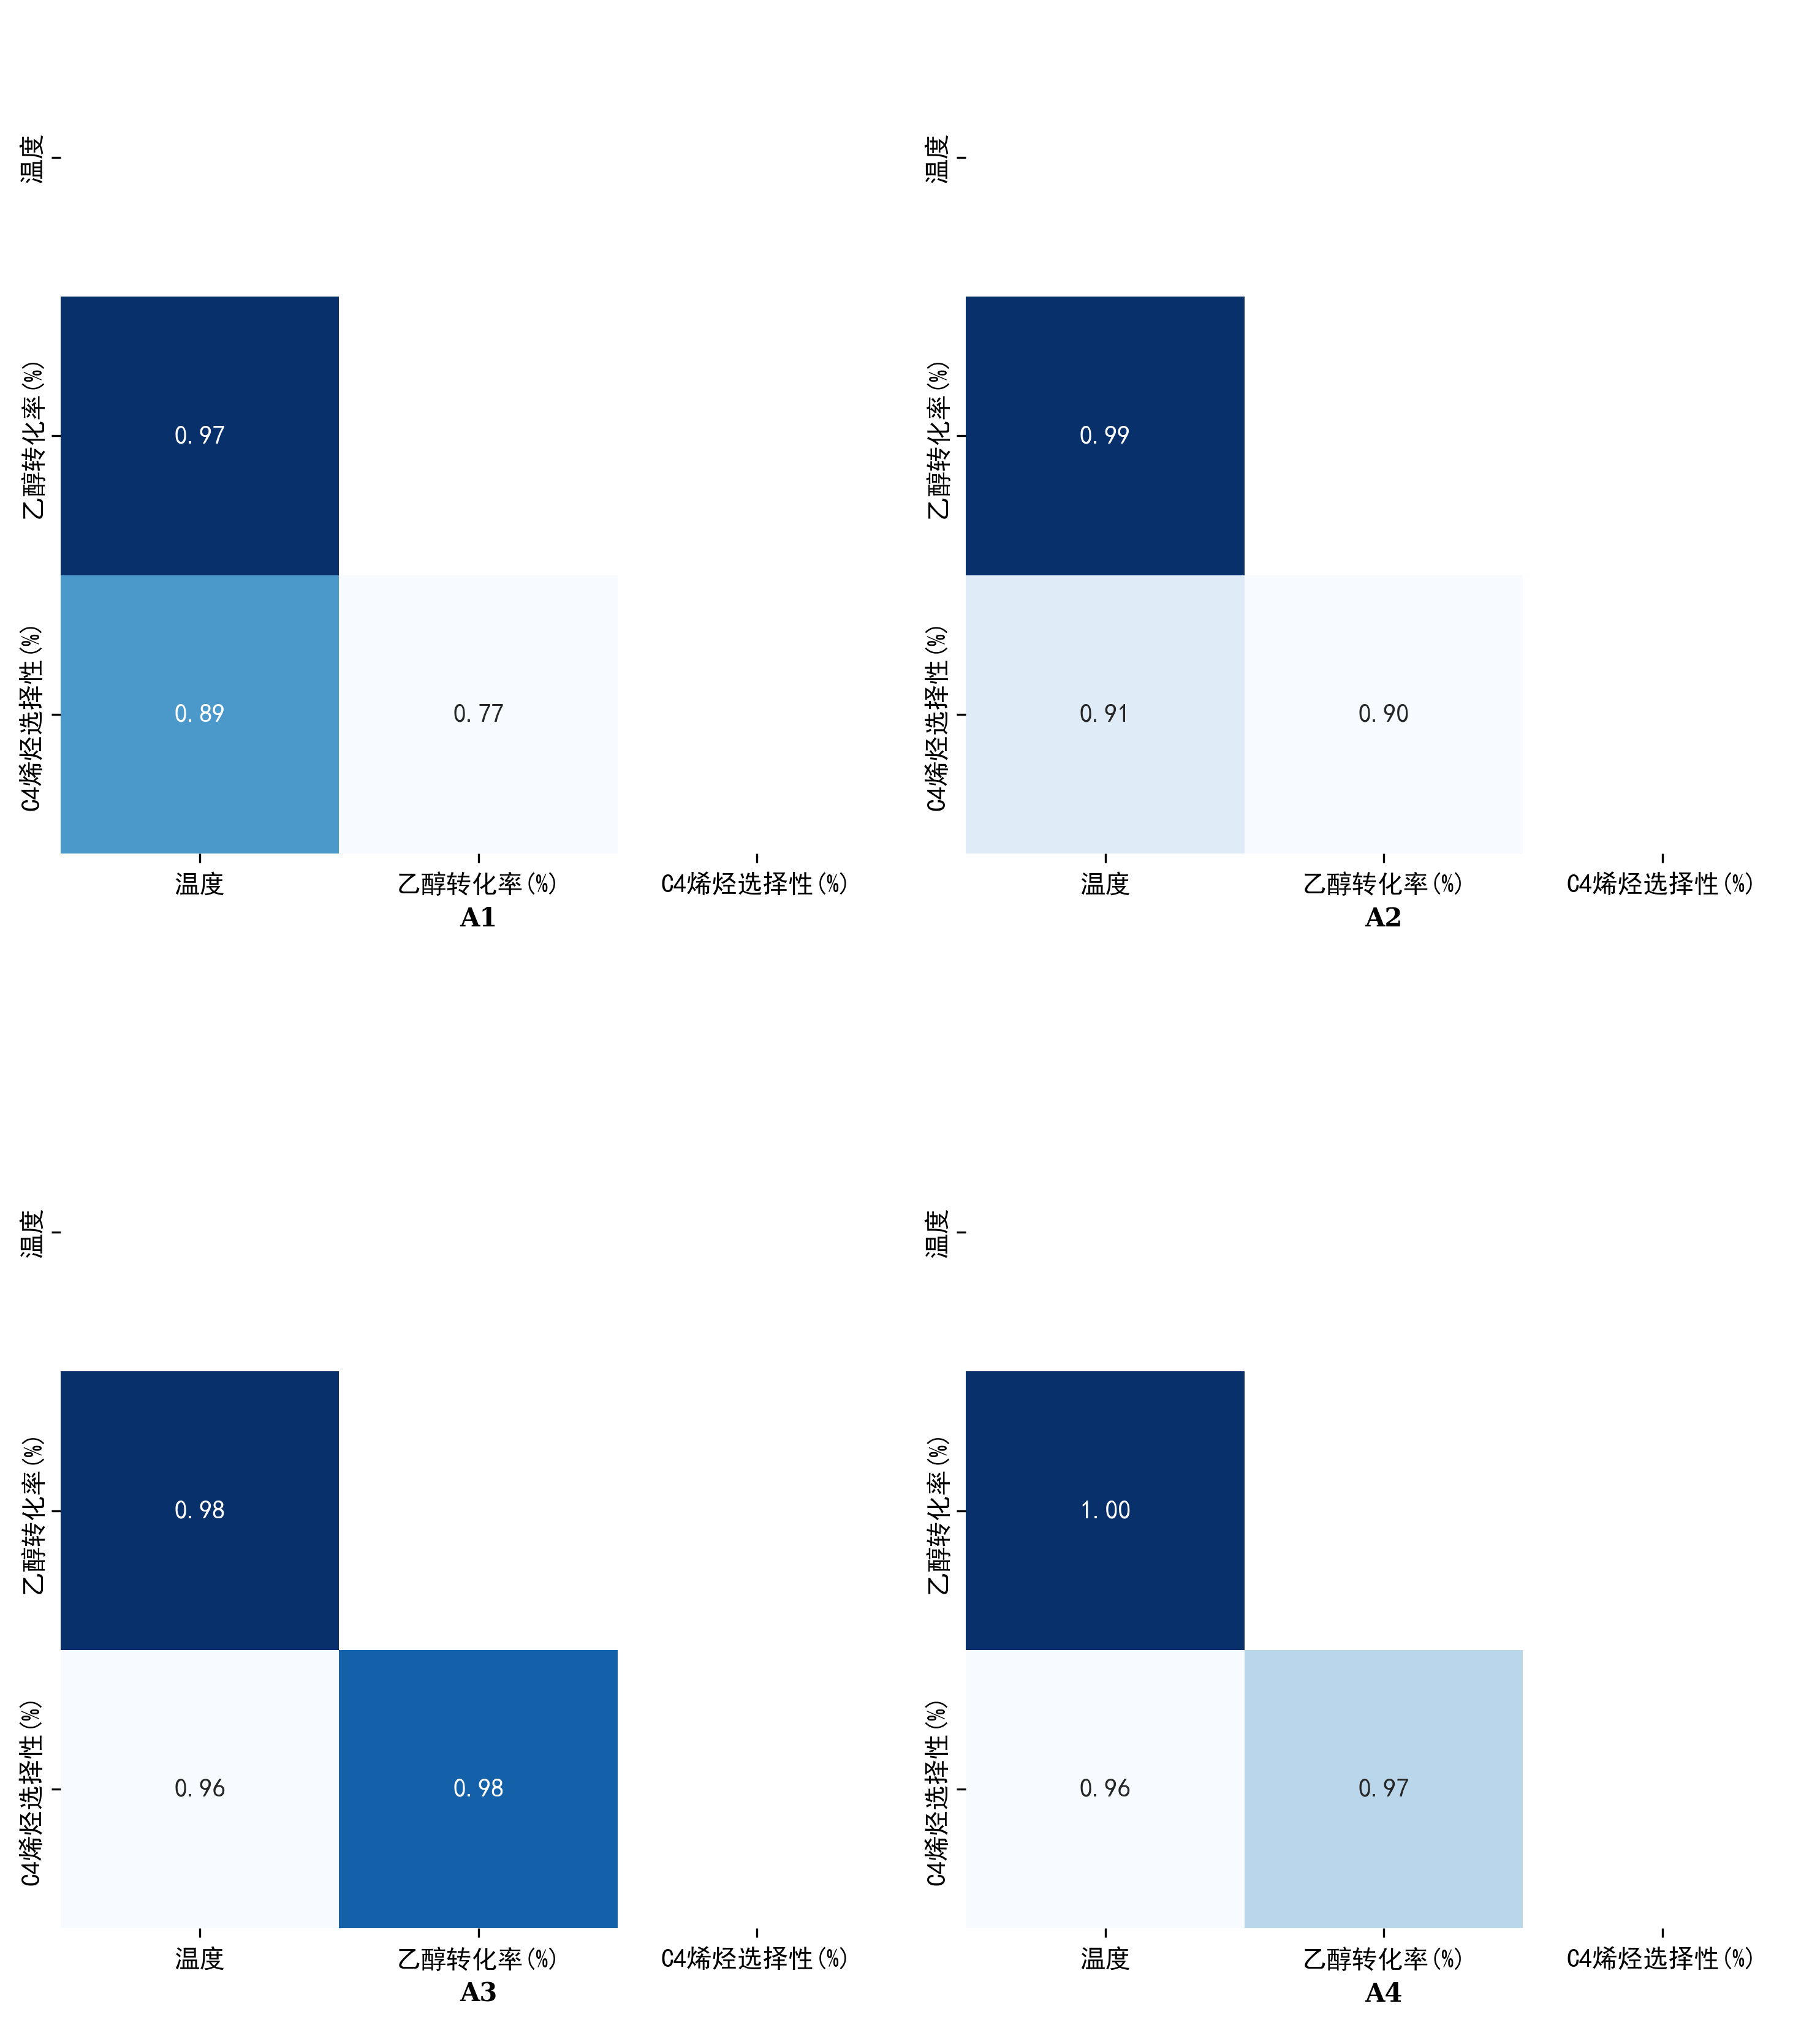

In [3]:
group = data.groupby('ID', sort=False)['温度','乙醇转化率(%)','C4烯烃选择性(%)']
group_idx = data['ID'].unique().tolist()
# ['温度','乙醇转化率(%)','C4烯烃选择性(%)']
df_list = [each[1] for each in group]

plt.figure(figsize=(10,70),dpi=300)
for idx,i in enumerate(df_list):
    ax = plt.subplot(12,2,idx+1)
    
    column = i.columns.tolist()  
    mcorr = i[column].corr(method="spearman")  
    mask = np.zeros_like(mcorr, dtype=np.bool)  
    mask[np.triu_indices_from(mask)] = True  

    sns.heatmap(i.corr(), mask=mask, square=True,cbar=False, cmap="Blues",annot=True, fmt='0.2f')
    ax.set_xlabel(group_idx[idx], fontfamily='serif', fontsize=10, weight='bold')
    
    # 控制打印的数目
    if idx == 3:
        break

plt.tight_layout()
plt.show()


大致绘制一下乙醇转化率、C4烯烃选择性与温度的变化曲线

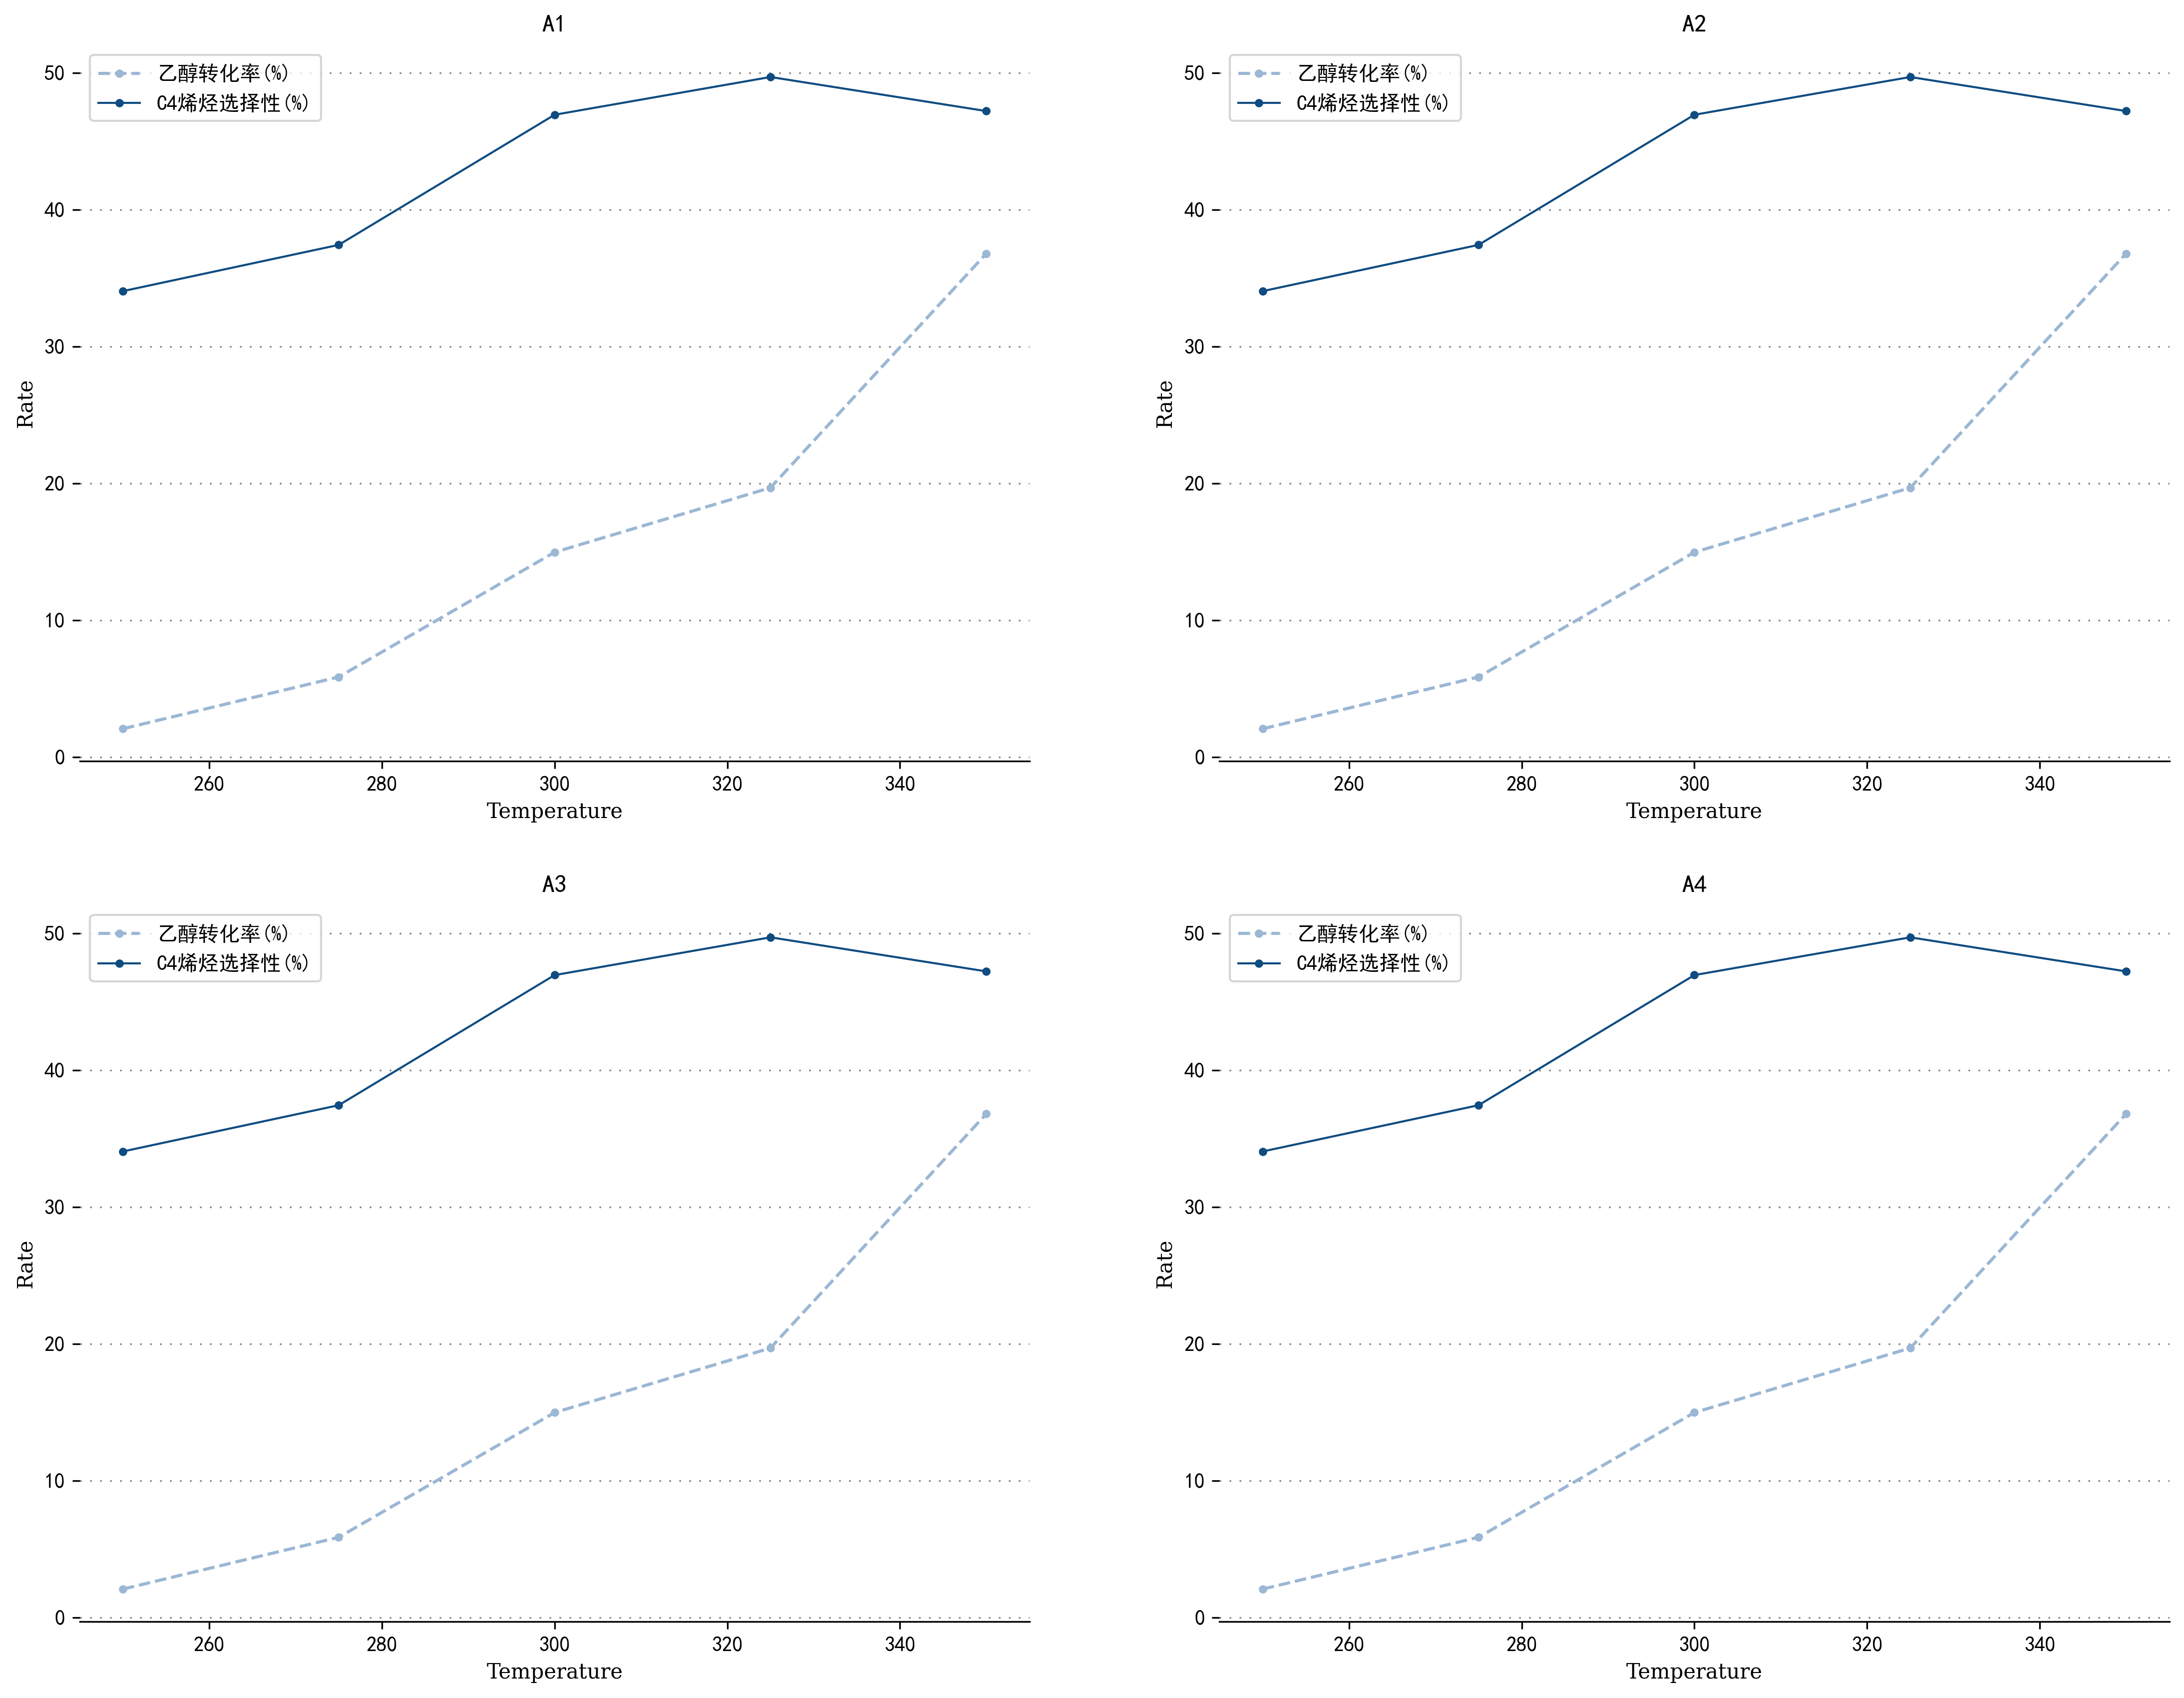

In [4]:
plt.figure(figsize=(18,90),dpi=300)
for idx,i in enumerate(df_list):
    ax = plt.subplot(12,2,idx+1)
    x = df_list[0]['温度'].values.tolist()
    y1 = df_list[0]['乙醇转化率(%)'].values.tolist()
    y2 = df_list[0]['C4烯烃选择性(%)'].values.tolist()
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    
    ax.plot(x, y1, '.--', label='乙醇转化率(%)',color='#9bb7d4')
    ax.plot(x, y2, '.-', linewidth=1,label='C4烯烃选择性(%)',color='#0f4c81')
    
    for direction in ['top','right','left']:
        ax.spines[direction].set_visible(False)
            
    plt.xlabel('Temperature',fontfamily='serif')
    plt.ylabel('Rate', fontfamily='serif')
    plt.legend()
    plt.title(group_idx[idx],weight='bold')
    
    # 控制打印数目
    if idx == 3:
        break
    
plt.show() 


* 可以观察到每一组的C4选择性都有一个先升高在下降的过程,趋势大致可以用2次或3次曲线进行拟合
* 每一组的乙烯转化率都会随温度上升,但是考虑到不能到达100%,所以应该是类似于logistic类型阻塞曲线

为了限定[乙醇转化率(%)]和[C4烯烃选择性(%)]的范围使用$\ln\frac{y}{100-y}$的方式

In [5]:
from scipy.optimize import curve_fit

def func1 (x, a,b,c):
    return 1/(a+b*np.exp(-c*x))
    
def func2 (x, a,b,c):
    return a*x**2+b*x+c

def func3 (x,a,b):
    return a*x+b

param_list = []
param_list2 = []

plt.figure(figsize=(18,90),dpi=300)
for idx,i in enumerate(df_list):
    x1 = [i for i in df_list[idx]['温度'].values.tolist()]
    x2 = [i for i in df_list[idx]['温度'].values.tolist()]
    y1 = np.array([np.log(i/(100-i)) for i in df_list[idx]['乙醇转化率(%)'].values.tolist()])
    y2 = np.array([np.log(i/(100-i)) for i in df_list[idx]['C4烯烃选择性(%)'].values.tolist()])
#     x1.extend([5])
#     y1.extend([100])
    x2 = np.array(x2)
    popt1, pcov1 = curve_fit(func3, x1, y1)
    popt2, pcov2 = curve_fit(func2, x2, y2)
    
    x_new = np.linspace(250,800,25)
    
    y_fit_1 = np.array([np.exp(func3(item, *popt1))*100/(np.exp(func3(item, *popt1))+1) for item in x_new])
    y_fit_2 = np.array([np.exp(func2(item, *popt2))*100/(np.exp(func2(item, *popt2))+1) for item in x_new])
    
    param_list.append(popt1)
    param_list2.append(popt2)
    
#     # 控制打印数目
#     if idx > 3:
#         continue
    
    ax = plt.subplot(12,2,idx+1)
    
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    
    ax.plot(x1, np.exp(y1)*100/(np.exp(y1)+1), '.', markersize=10,label='乙醇转化率(%)',color='#9bb7d4')
    ax.plot(x2, np.exp(y2)*100/(np.exp(y2)+1), '.', markersize=10,label='C4烯烃选择性(%)',color='#0f4c81')
    ax.plot(x_new, y_fit_1, '', linewidth=2,label='乙醇转化率(%)',color='#9bb7d4' )
    ax.plot(x_new, y_fit_2, '', linewidth=2,label='C4烯烃选择性(%)',color='#0f4c81')

    for direction in ['top','right','left']:
        ax.spines[direction].set_visible(False)
    
    plt.title(group_idx[idx],weight='bold')
    plt.xlabel('Temperature(x100)',fontfamily='serif',weight='bold',loc='right')

    plt.ylabel('Rate(%)', fontfamily='serif',weight='bold',loc='top')
    plt.legend()
    
plt.tight_layout()
plt.show()


In [6]:
data2 = pd.read_excel('data2.xlsx', skiprows=3, header=None)
data2.head()

0          1     2      3     4      5     6      7
0   20  43.547389  4.23  39.90  5.17  39.70  2.58   8.42
1   70  37.788146  4.28  38.55  5.60  37.36  4.28   9.93
2  110  36.556360  4.46  36.72  6.37  32.39  4.63  15.43
3  163  32.721857  4.63  39.53  7.82  31.29  4.80  11.93
4  197  31.710097  4.62  38.96  8.19  31.49  4.26  12.48

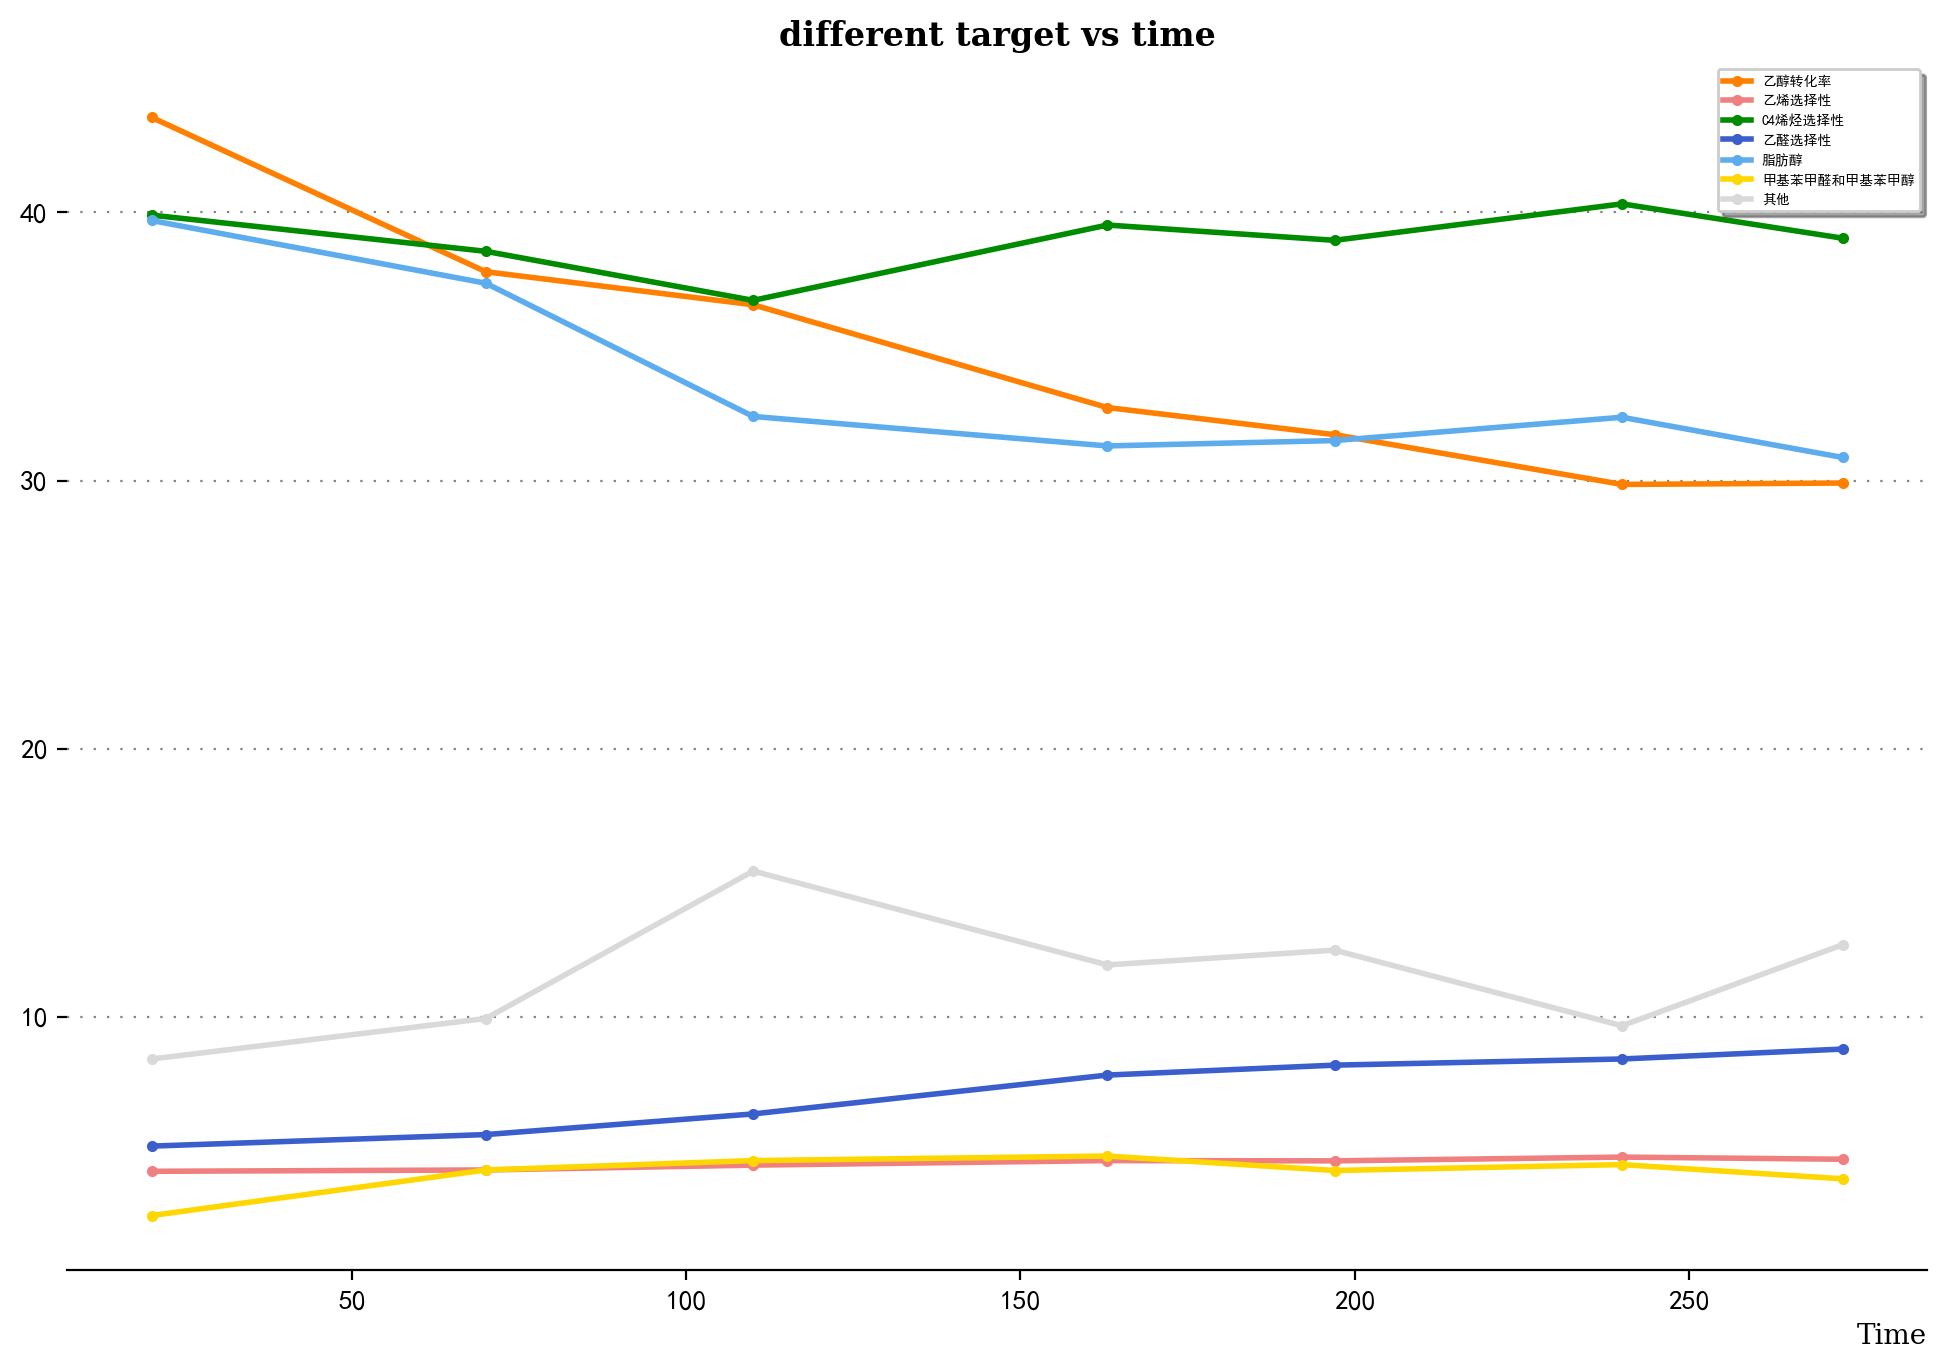

In [7]:
time = data2[0].values.tolist()
plt.figure(figsize=(12,8),dpi=200)
ax = plt.subplot(1,1,1)
colors = ["#FF7F00","#F08080","#008B00","#3A5FCD","#5CACEE","#FFD700","#D9D9D9"]
labels = ['乙醇转化率','乙烯选择性','C4烯烃选择性','乙醛选择性','脂肪醇','甲基苯甲醛和甲基苯甲醇','其他']
for i in range(1,8):
    y = data2[i].values.tolist()
    ax.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
    
    ax.plot(time, y, '.-', linewidth=2,color=colors[i-1],label=labels[i-1])

    for direction in ['top','right','left']:
        ax.spines[direction].set_visible(False)
    plt.legend(loc='upper right',fontsize=5,shadow=True)
    plt.title('different target vs time', fontfamily='serif',weight='bold')
    ax.set_xlabel('Time',loc='right',fontfamily='serif')
    
plt.show()

In [8]:
temp_list = [250,275,300,325,350,400]

data_int1 = pd.read_excel('data3_1.xlsx',header=None)
data_int1.fillna(0,inplace=True)

for i in data_int1.columns:
    data_list = data_int1.iloc[:,i].values.tolist()
    if 0 in data_list:
        int_idx = data_list.index(0)
        X = [item for idx,item in enumerate(temp_list) if idx != int_idx]
        Y = [item for idx,item in enumerate(data_list) if idx != int_idx]
        int_x = temp_list[int_idx]
        e = np.exp(func3(int_x, *param_list[i]))
        int_y = e*100/(e+1)
        data_int1[i][int_idx] = int_y

data_int1.to_excel('data_new_3_1.xlsx', sheet_name='Sheet1',index=False)# index = False表示不写入索引
        
data_int1

0          1          2          3          4          5   \
0   2.067169   4.602997   9.669373   4.019391  14.787183  13.389397   
1   5.851721  17.195539  19.236935  12.097758  12.424011  12.780991   
2  14.968891  38.922245  29.250234  29.476564  20.808576  25.479216   
3  19.681359  56.382460  37.579185  43.325622  28.348886  41.192112   
4  36.801017  67.879296  48.937045  60.468428  36.811579  55.755027   
5  75.740758  95.004104  83.713382  88.439344  76.019832  83.347616   

          6          7          8          9   ...         11         12  \
0  19.656291   6.265737   2.053162   0.319964  ...   1.441709   1.346948   
1  29.044956   8.761570   3.002572   1.015453  ...   3.473630   2.305456   
2  39.984366  13.179048   4.729201   1.684676  ...   6.914388   4.066729   
3  48.173993  21.592655   9.252876   3.892157  ...  11.001522   8.231835   
4  58.604997  31.720663  13.392745   9.018841  ...  19.912298  14.638776   
5  76.027416  56.116390  40.797163  28.594391  ...  44.534967  40.047154   

          13         14         15         16         17         18  \
0   2.492689   1.408182   2.763024   0.394774   0.543984   2.121247   
1   5.334835   3.417914   4.402661   0.615198   1.113157   3.833571   
2  10.152036   6.723726   6.223563   1.148948   3.014985   5.812120   
3  15.461389  10.704366  11.745798   3.285213   6.055178   9.784285   
4  24.031899  19.309263  16.187032   6.010300   9.643361  15.863261   
5  53.615257  43.595444  45.135239  21.100130  33.489596  44.981882   

          19    20  
0   2.768169   4.4  
1   7.510253   7.9  
2  12.619238  11.7  
3  15.858964  17.8  
4  27.030963  30.2  
5  63.245238  69.4  

[6 rows x 21 columns]

In [9]:
temp_list = [250,275,300,325,350,400]

data_int2 = pd.read_excel('data3_2.xlsx',header=None)
data_int2.fillna(0,inplace=True)

for i in data_int2.columns:
    data_list = data_int2.iloc[:,i].values.tolist()
    if 0 in data_list:
        int_idx = data_list.index(0)
        X = [item for idx,item in enumerate(temp_list) if idx != int_idx]
        Y = [item for idx,item in enumerate(data_list) if idx != int_idx]
        int_x = temp_list[int_idx]
        e = np.exp(func2(int_x, *param_list2[i]))
        int_y = e*100/(e+1)
        data_int2[i][int_idx] = int_y
        
data_int2.to_excel('data_new_3_2.xlsx', sheet_name='Sheet1',index=False)# index = False表示不写入索引

data_int2

0          1      2      3      4          5          6         7   \
0  34.050000  18.070000   5.50   9.62   1.96   3.300000   5.750000   5.63000   
1  37.430000  17.280000   8.04   8.62   6.65   7.100000   6.560000   8.52000   
2  46.940000  19.600000  17.01  10.72  10.12   7.180000   8.840000  13.82000   
3  49.700000  30.620000  28.72  18.89  13.86   9.320306  12.515967  19.20596   
4  47.210000  39.100000  36.85  27.25  18.75  10.650000  18.640000  25.89000   
5  39.683519  78.606302  53.43  41.02  38.23  37.330000  33.250000  41.42000   

          8          9   ...         11         12         13         14  \
0   5.400000   2.190000  ...   6.170000   5.190000   1.890000   6.320000   
1   9.680000   1.650000  ...   8.110000   7.620000   2.550000   8.250000   
2  16.100000   2.170000  ...  11.220000  12.740000   3.610000  12.280000   
3  23.438416   2.384362  ...  15.819046  17.681106   6.174269  17.845361   
4  31.040000   3.300000  ...  22.260000  23.460000  10.830000  25.970000   
5  42.040000  10.290000  ...  36.300000  27.910000  22.300000  41.080000   

          15     16     17     18     19     20  
0   3.260000   2.85   6.62   4.30   4.50   4.08  
1   4.970000   5.35   6.62   5.06   4.79   6.62  
2   9.320000   7.61   5.05   7.92   8.77  12.86  
3  14.717917   7.74   8.33  11.69  16.06  18.45  
4  22.880000  13.81  13.10  15.34  22.41  25.05  
5  38.700000  21.21  21.45  25.83  30.48  38.17  

[6 rows x 21 columns]

根据题目有**Co负载量、Co/SiO2的质量、HAP质量、加入乙醇的速度、温度因素**来导致**C4烯烃吸率**的不同

以此来构建预测模型

In [84]:
data4 = pd.read_excel('data4.xlsx')
y = data4['C4烯烃收率'].values[:69]
X = data4.drop(columns=['C4烯烃收率','乙醇转化率','C4烯烃选择性']).values[:69]

用XGboost对5个自变量$x_1,x_2,x_3,x_4,x_5$进行预测,得到在训练集上的R方为0.97,在测试集上的R方为0.90

In [87]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error,r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
param_grid = {'n_estimators': [25,50,100,120],
              'max_depth': [1,2,4,6]}
xgb = XGBRegressor()
gsearch = GridSearchCV(xgb, param_grid=param_grid, cv=5)
gsearch.fit(X_train,y_train)

model = gsearch.best_estimator_
y_pred = model.predict(X_test)
print("R^2 on test data: ", r2_score(y_test,y_pred))
print("R^2 on train data: ", r2_score(y_train,model.predict(X_train)))
print(gsearch.best_params_)


R^2 on test data:  0.9006843004344881
R^2 on train data:  0.9701795969342876
{'max_depth': 2, 'n_estimators': 100}


In [88]:
import geatpy as ea
import time

"""============================目标函数============================"""
def aim(Phen):  # 传入种群染色体矩阵解码后的基因表现型矩阵
    NIND = Phen.shape[0]
    result = np.zeros((NIND,1))
    for i in range(NIND):
        x_pred = np.array([Phen[i,:]])
        y_pred = model.predict(x_pred)
        result[i] = y_pred
        
    return -result
        

"""============================变量设置============================"""
range1 = [250,400] # 温度范围
range2 = [33,200]  # Co/SiO2质量
range3 = [0.5,5]   # Co负载量
range4 = [33,200]  # HAP质量
range5 = [0.3,2.1] # 乙醇添加速度

b = np.tile([1, 1],(5,1))  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含

# 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
ranges = np.vstack([range1,range2,range3,range4,range5])
ranges = ranges.T

# 生成自变量的边界矩阵
borders = b.T

varTypes = np.array([0]*5)  # 决策变量的类型，0表示连续，1表示离散

"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [1]*5  # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions = [2]*5  # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0]*5  # 0表示采用算术刻度，1表示采用对数刻度#调用函数创建译码矩阵
FieldD = ea.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)

"""=========================遗传算法参数设置========================"""
NIND = 30  # 种群个体数目
MAXGEN = 2000  # 最大遗传代数
maxormins = np.array([1])  # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
pc = 0.9  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体

"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ea.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
variable = ea.bs2ri(Chrom, FieldD)  # 对初始种群进行解码
ObjV = aim(variable)  # 计算初始种群个体的目标函数值
best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)  # 根据目标函数大小分配适应度值
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    SelCh = ea.recombin(recStyle, SelCh, pc)  # 重组
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    # 把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ea.bs2ri(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen)  # 求种群个体的目标函数值
    # 记录
    best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    # 进化完成
    end_time = time.time()  # 结束计时
# ea.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像

"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i + 1) + '=', variable[0, i])

print('用时：', end_time - start_time, '秒')

最优解的目标函数值： -4298.65869140625
最优解的决策变量值为：
x1= 394.65299395715067
x2= 197.7727896969512
x3= 0.6056751467710372
x4= 134.97259437849056
x5= 1.2458823529411764
用时： 201.47756671905518 秒


In [89]:
import geatpy as ea
import time

"""============================目标函数============================"""
def aim(Phen):  # 传入种群染色体矩阵解码后的基因表现型矩阵
    NIND = Phen.shape[0]
    result = np.zeros((NIND,1))
    for i in range(NIND):
        x_pred = np.array([Phen[i,:]])
        y_pred = model.predict(x_pred)
        result[i] = y_pred
        
    return -result
        

"""============================变量设置============================"""
range1 = [250,350] # 温度范围
range2 = [33,200]  # Co/SiO2质量
range3 = [0.5,5]   # Co负载量
range4 = [33,200]  # HAP质量
range5 = [0.3,2.1] # 乙醇添加速度

b = np.tile([1, 1],(5,1))  # 第一个决策变量边界，1表示包含范围的边界，0表示不包含

# 生成自变量的范围矩阵，使得第一行为所有决策变量的下界，第二行为上界
ranges = np.vstack([range1,range2,range3,range4,range5])
ranges = ranges.T

# 生成自变量的边界矩阵
borders = b.T

varTypes = np.array([0]*5)  # 决策变量的类型，0表示连续，1表示离散

"""==========================染色体编码设置========================="""
Encoding = 'BG'  # 'BG'表示采用二进制/格雷编码
codes = [1]*5  # 决策变量的编码方式，两个1表示变量均使用格雷编码
precisions = [2]*5  # 决策变量的编码精度，表示解码后能表示的决策变量的精度可达到小数点后6位
scales = [0]*5  # 0表示采用算术刻度，1表示采用对数刻度#调用函数创建译码矩阵
FieldD = ea.crtfld(Encoding, varTypes, ranges, borders, precisions, codes, scales)

"""=========================遗传算法参数设置========================"""
NIND = 30  # 种群个体数目
MAXGEN = 2000  # 最大遗传代数
maxormins = np.array([1])  # 表示目标函数是最小化，元素为-1则表示对应的目标函数是最大化
selectStyle = 'sus'  # 采用随机抽样选择
recStyle = 'xovdp'  # 采用两点交叉
mutStyle = 'mutbin'  # 采用二进制染色体的变异算子
Lind = int(np.sum(FieldD[0, :]))  # 计算染色体长度
pc = 0.9  # 交叉概率
pm = 1 / Lind  # 变异概率
obj_trace = np.zeros((MAXGEN, 2))  # 定义目标函数值记录器
var_trace = np.zeros((MAXGEN, Lind))  # 染色体记录器，记录历代最优个体的染色体

"""=========================开始遗传算法进化========================"""
start_time = time.time()  # 开始计时
Chrom = ea.crtpc(Encoding, NIND, FieldD)  # 生成种群染色体矩阵
variable = ea.bs2ri(Chrom, FieldD)  # 对初始种群进行解码
ObjV = aim(variable)  # 计算初始种群个体的目标函数值
best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号

# 开始进化
for gen in range(MAXGEN):
    FitnV = ea.ranking(maxormins * ObjV)  # 根据目标函数大小分配适应度值
    SelCh = Chrom[ea.selecting(selectStyle, FitnV, NIND - 1), :]  # 选择
    SelCh = ea.recombin(recStyle, SelCh, pc)  # 重组
    SelCh = ea.mutate(mutStyle, Encoding, SelCh, pm)  # 变异
    # 把父代精英个体与子代的染色体进行合并，得到新一代种群
    Chrom = np.vstack([Chrom[best_ind, :], SelCh])
    Phen = ea.bs2ri(Chrom, FieldD)  # 对种群进行解码(二进制转十进制)
    ObjV = aim(Phen)  # 求种群个体的目标函数值
    # 记录
    best_ind = np.argmin(ObjV)  # 计算当代最优个体的序号
    obj_trace[gen, 0] = np.sum(ObjV) / ObjV.shape[0]  # 记录当代种群的目标函数均值
    obj_trace[gen, 1] = ObjV[best_ind]  # 记录当代种群最优个体目标函数值
    var_trace[gen, :] = Chrom[best_ind, :]  # 记录当代种群最优个体的染色体
    # 进化完成
    end_time = time.time()  # 结束计时
# ea.trcplot(obj_trace, [['种群个体平均目标函数值', '种群最优个体目标函数值']])  # 绘制图像

"""============================输出结果============================"""
best_gen = np.argmin(obj_trace[:, [1]])
print('最优解的目标函数值：', obj_trace[best_gen, 1])
variable = ea.bs2ri(var_trace[[best_gen], :], FieldD)  # 解码得到表现型（即对应的决策变量值）
print('最优解的决策变量值为：')
for i in range(variable.shape[1]):
    print('x' + str(i + 1) + '=', variable[0, i])

print('用时：', end_time - start_time, '秒')

最优解的目标函数值： -2045.9808349609375
最优解的决策变量值为：
x1= 340.81975218214
x2= 188.41544846949674
x3= 2.287671232876712
x4= 41.88845484786523
x5= 1.0835294117647059
用时： 195.72514462471008 秒


In [ ]:
def huitu():
    # 画布
    fig = plt.figure(figsize=(12, 6),facecolor='white')
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    fig.subplots_adjust(wspace=0)

    # 定义数据
    data1 = data['gender'].value_counts()
    
    x = [data[data['stroke']==1]['gender'].value_counts()['Female'],data[data['stroke']==0]['gender'].value_counts()['Female']]
    label = ['stroke','non stroke']
    
    x2 = [data[data['stroke']==1]['gender'].value_counts()['Male'],data[data['stroke']==0]['gender'].value_counts()['Male']]
    label2 = ['stroke','non stroke']
    
    # 大饼图
    explode = (0, 0.03)    # 分裂距离
    
    ax1.pie(x=x2,
            colors=['#A9A780', '#A7A0A7'],
            autopct='%1.1f%%',
            startangle=70,
            labels=label2,
            radius=0.5,
            textprops={'color': 'k',
                       'font': 'Times New Roman',
                       'fontsize': 15,
            }
        )

    ax2.pie(data1,
            colors=['#A9A780', '#E28081'],
            explode=explode,
            autopct='%1.1f%%',
            textprops={'color': 'k',
                       'font': 'Times New Roman',
                       'fontsize': 17,
                      }
            ,startangle=60
           )

    axcoordsA='data',3.pie(x=x,
            colors=['#A9A780', '#A7A0A7'],
            autopct='%1.1f%%',
            startangle=70,
            labels=label,
            radius=0.5,
            textprops={'color': 'k',
                       'font': 'Times New Roman',
                       'fontsize': 15,
                      },
           )

    # 用 ConnectionPatch 画出两个饼图的间连线
    ## 饼图边缘的数据
    theta1 = ax2.patches[-1].theta1
    theta2 = ax2.patches[-1].theta2
    center = ax2.patches[-1].center
    r = ax2.patches[-1].r

    width=0.2
    # 上边缘的连线
    x = r*np.cos(np.pi/180*theta2)+center[0]
    y = np.sin(np.pi/180*theta2)+center[1]
    con_a = ConnectionPatch(xyA=(-width/2,0.5), xyB=(x,y),
                            coordsA='data', coordsB='data',
                            axesA=ax3, axesB=ax2
                           )

    # 下边缘的连线
    x = r*np.cos(np.pi/180*theta1)+center[0]
    y = np.sin(np.pi/180*theta1)+center[1]
    con_b = ConnectionPatch(xyA=(-width/2,-0.5), xyB=(x,y),
                            coordsA='data', coordsB='data',
                            axesA=ax3, axesB=ax2
                           )
    
    # 用 ConnectionPatch 画出两个饼图的间连线
    ## 饼图边缘的数据
    theta1 = ax2.patches[-1].theta1 - 15
    theta2 = ax2.patches[-1].theta2 + 35
    center = ax2.patches[-1].center
    r = ax2.patches[-1].r

    width=0.2
    # 上边缘的连线
    x = r*np.cos(np.pi/180*theta2)+center[0]
    y = np.sin(np.pi/180*theta2)+center[1]
    con_a2 = ConnectionPatch(xyA=(-width/2,0.5), xyB=(x,y),
                            coordsA='data', coordsB='data',
                            axesA=ax1, axesB=ax2,color='r'
                           )

    # 下边缘的连线
    x = r*np.cos(np.pi/180*theta1)+center[0]
    y = np.sin(np.pi/180*theta1)+center[1]
    con_b2 = ConnectionPatch(xyA=(-width/2,-0.5), xyB=(x,y),
                            coordsA='data', coordsB='data',
                            axesA=ax1, axesB=ax2,color='b'
                           )
    

    for con in [con_a, con_b,con_a2,con_b2]:
        con.set_linewidth(1)    # 连线宽度
        con.set_color=([0,0,0])    # 连线颜色
        ax2.add_artist(con)   # 添加连线

huitu()
